In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell, MaxPooling1D,Flatten

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read the consumption data
#It is available as a txt file. Data is courtesy of UCI @ https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

consDataDf = pd.read_csv("household_power_consumption.txt",low_memory=False,sep=";")#,sep=";",dtype=)

In [4]:
#Data is stored as a 2 million rows 9 column dataset
#The usable Date and Time columns can be used as a reference index. Global Active Power should be used as the power consumption variable
print(consDataDf.shape)
consDataDf.head()

(2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
consDataDf.dtypes #Observe the column datatypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [7]:
#Create a Datetime column out of the existing columns
consDataDf['DateTime'] = pd.to_datetime(consDataDf['Date'] + ' ' + consDataDf['Time'])

In [9]:
#Extract only the column we're going to use
dataDf = consDataDf[['Global_active_power']]

In [10]:
#sum to check #.isna()
dataDf['Global_active_power'].replace(to_replace='?',value=np.nan).isna().sum()

25979

In [11]:
#Replace all ? chars with nan
dataDf['Global_active_power'] = dataDf['Global_active_power'].replace(to_replace='?',value=np.nan).ffill()

In [12]:
#Convert to numeric for timeseries analysis
dataDf['Global_active_power'] = pd.to_numeric(dataDf['Global_active_power'])#,errors='coerce')

In [14]:
KERNEL_WIDTH = 6

In [46]:
train_df = dataDf[:int(0.8*len(dataDf))]
val_df = dataDf[1660208:int(0.9*len(dataDf))]
test_df = dataDf[int(0.9*len(dataDf))+1:]

In [48]:
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [16]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [17]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [19]:
conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1,label_columns=['Global_active_power']) 
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_conv_window = DataWindow(input_width=INPUT_WIDTH,label_width=LABEL_WIDTH, shift=1, label_columns=['Global_active_power'])

cnn_model = Sequential([
    Conv1D(filters=32,kernel_size=(KERNEL_WIDTH,),activation='relu'),
    Dense(units=32,activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}
val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

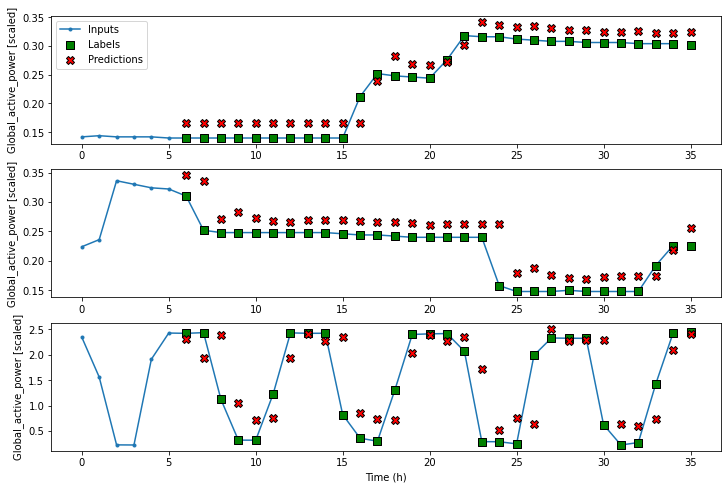

In [146]:
wide_conv_window.plot(model=cnn_model,plot_col='Global_active_power')

In [117]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
           kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32,return_sequences=True),
    LSTM(32,return_sequences=True),
    Dense(units=1)
]
)

history = compile_and_fit(cnn_lstm_model,conv_window)
val_performance['CNN_LSTM'] = cnn_model.evaluate(conv_window.val)
performance['CNN_LSTM'] = cnn_model.evaluate(conv_window.test)

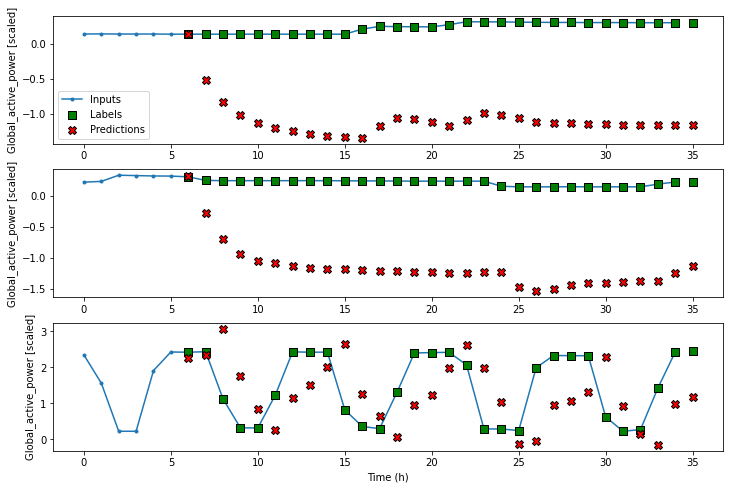

In [147]:
wide_conv_window.plot(model=cnn_lstm_model,plot_col='Global_active_power')

In [25]:
val_performance

{}

CNN Multi-Step model

In [20]:
KERNEL_WIDTH = 6
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1
 
multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,shift=24, label_columns=['Global_active_power'])

In [21]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

In [22]:
history = compile_and_fit(ms_cnn_model,multi_window)

ms_val_performance = {}
ms_performance = {}
 
ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

ms_cnn_lstm_model = Sequential([
    Conv1D(24, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(24, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
51880/51880 [==============================] - 67s 1ms/step - loss: 0.6097 - mean_absolute_error: 0.4698 - val_loss: 0.4965 - val_mean_absolute_error: 0.4497
Epoch 2/50
51880/51880 [==============================] - 66s 1ms/step - loss: 0.6011 - mean_absolute_error: 0.4658 - val_loss: 0.4822 - val_mean_absolute_error: 0.4268
Epoch 3/50
51880/51880 [==============================] - 67s 1ms/step - loss: 0.5994 - mean_absolute_error: 0.4651 - val_loss: 0.4906 - val_mean_absolute_error: 0.4442
Epoch 4/50
51880/51880 [==============================] - 67s 1ms/step - loss: 0.5984 - mean_absolute_error: 0.4647 - val_loss: 0.4785 - val_mean_absolute_error: 0.4232
Epoch 5/50
51880/51880 [==============================] - 68s 1ms/step - loss: 0.5977 - mean_absolute_error: 0.4644 - val_loss: 0.4797 - val_mean_absolute_error: 0.4287
Epoch 6/50
51880/51880 [==============================] - 69s 1ms/step - loss: 0.5973 - mean_absolute_error: 0.4643 - val_loss: 0.4804 - val_mean_absolute_

In [23]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [32]:
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [24]:
inputs , labels = split_sequence(train_df['Global_active_power'],3)

In [25]:
labels

array([5.388, 3.666, 3.52 , ..., 0.278, 0.344, 0.334])

In [26]:
n_features = 1
inputs = inputs.reshape((inputs.shape[0], inputs.shape[1], n_features))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(3, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.fit(inputs, labels, epochs=5, verbose=1)

Epoch 1/5
51882/51882 [==============================] - 22s 427us/step - loss: 0.0784
Epoch 2/5
51882/51882 [==============================] - 22s 423us/step - loss: 0.0741
Epoch 3/5
51882/51882 [==============================] - 22s 417us/step - loss: 0.0733
Epoch 4/5
51882/51882 [==============================] - 22s 431us/step - loss: 0.0727
Epoch 5/5
51882/51882 [==============================] - 22s 429us/step - loss: 0.0723


In [53]:
test_inputs,test_labels = split_sequence(test_df['Global_active_power'],3)

In [54]:
test_inputs = test_inputs.reshape((test_inputs.shape[0], test_inputs.shape[1], n_features))
yhat = model.predict(test_inputs, verbose=0)
print(yhat)

[[0.35385048]
 [0.35331792]
 [0.3498459 ]
 ...
 [0.9754189 ]
 [0.972457  ]
 [0.96717143]]


In [61]:
yhat_sample = yhat[800:1000]
test_labels_sample = test_labels[800:1000]

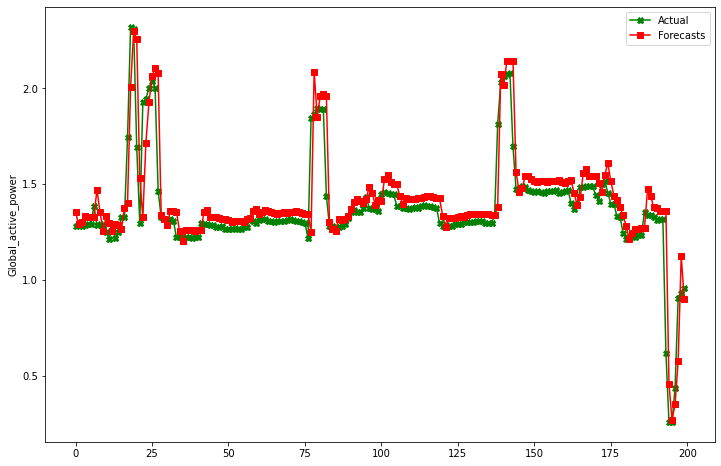

In [62]:
plt.figure(figsize=(12, 8))
plt.ylabel('Global_active_power')
plt.plot(test_labels_sample,c='green',marker='X',label='Actual')
plt.plot(yhat_sample,c='red',marker='s',label='Forecasts')
plt.legend()

In [71]:
m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(test_labels_sample, yhat_sample)
m.result().numpy()

6.2701573

In [77]:
dataDf.set_index(consDataDf['DateTime'],inplace=True)

In [80]:
dataDf['dayOfYear'] = dataDf.index.dayofyear

In [81]:
dataDf['hourOfDay'] = dataDf.index.hour

In [82]:
dataDf['dayOfWeek'] = dataDf.index.weekday

In [83]:
dataDf['monthOfYear'] = dataDf.index.month

In [84]:
dataDf['weekOfYear'] = dataDf.index.week

In [85]:
dataDf['year'] = dataDf.index.year

In [86]:
dataDf['minOfHour'] = dataDf.index.minute

In [87]:
dataDf.head()

,Global_active_power,dayOfYear,hourOfDay,dayOfWeek,monthOfYear,weekOfYear,year,minOfHour
DateTime,,,,,,,,
2006-12-16 17:24:00,4.216,350,17,5,12,50,2006,24
2006-12-16 17:25:00,5.360,350,17,5,12,50,2006,25
2006-12-16 17:26:00,5.374,350,17,5,12,50,2006,26
2006-12-16 17:27:00,5.388,350,17,5,12,50,2006,27
2006-12-16 17:28:00,3.666,350,17,5,12,50,2006,28


In [88]:
dataDf.to_csv('dataDf.csv')

In [89]:
yearDataDict = {}
for year in dataDf['year'].unique():
    yearDataDict[year] = dataDf.loc[dataDf['year'] == year]

In [90]:
yearDataDict[2007].to_csv('dataDf2007.csv')

In [94]:
yearDataDict[2006].to_csv('dataDf2006.csv')
yearDataDict[2008].to_csv('dataDf2008.csv')
yearDataDict[2009].to_csv('dataDf2009.csv')
yearDataDict[2010].to_csv('dataDf2010.csv')

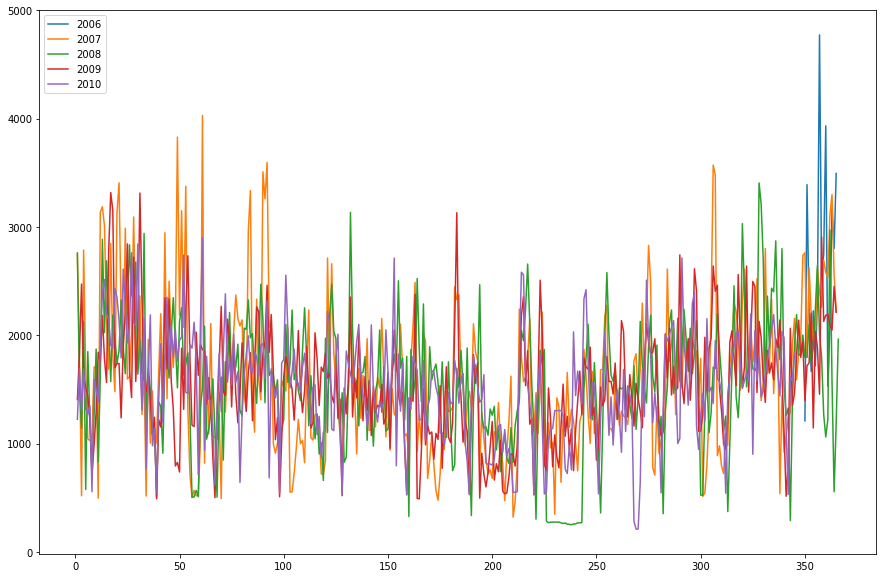

In [95]:
plt.figure(figsize=(15,10))
plt.plot(yearDataDict[2006].groupby(['dayOfYear'])['Global_active_power'].sum(),label='2006')
plt.plot(yearDataDict[2007].groupby(['dayOfYear'])['Global_active_power'].sum(),label='2007')
plt.plot(yearDataDict[2008].groupby(['dayOfYear'])['Global_active_power'].sum(),label='2008')
plt.plot(yearDataDict[2009].groupby(['dayOfYear'])['Global_active_power'].sum(),label='2009')
plt.plot(yearDataDict[2010].groupby(['dayOfYear'])['Global_active_power'].sum(),label='2010')
plt.legend()

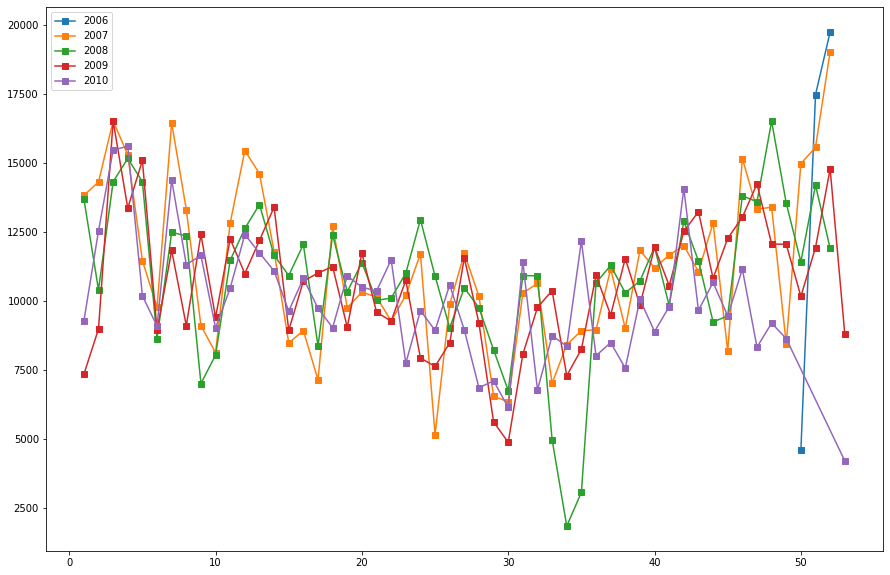

In [96]:
plt.figure(figsize=(15,10))
plt.plot(yearDataDict[2006].groupby(['weekOfYear'])['Global_active_power'].sum(),label='2006',marker='s')
plt.plot(yearDataDict[2007].groupby(['weekOfYear'])['Global_active_power'].sum(),label='2007',marker='s')
plt.plot(yearDataDict[2008].groupby(['weekOfYear'])['Global_active_power'].sum(),label='2008',marker='s')
plt.plot(yearDataDict[2009].groupby(['weekOfYear'])['Global_active_power'].sum(),label='2009',marker='s')
plt.plot(yearDataDict[2010].groupby(['weekOfYear'])['Global_active_power'].sum(),label='2010',marker='s')
plt.legend()

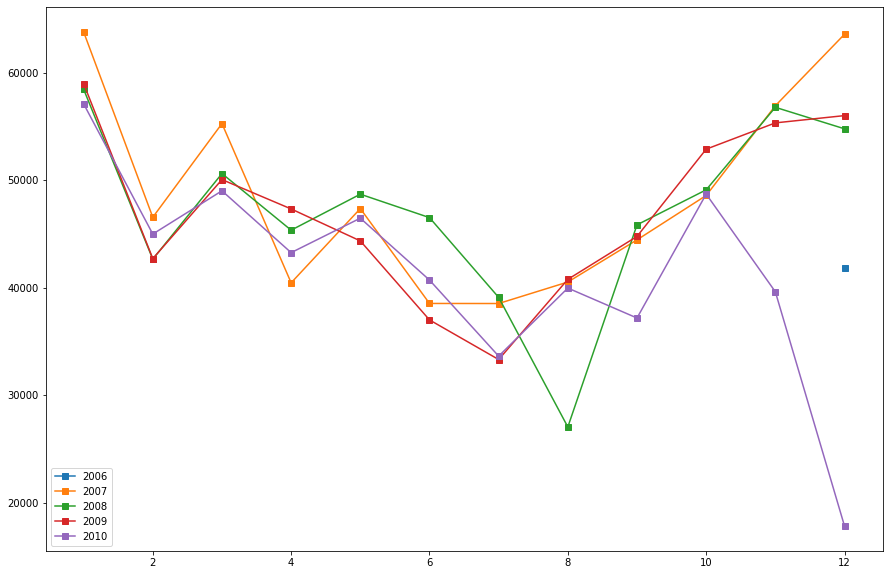

In [97]:
plt.figure(figsize=(15,10))
plt.plot(yearDataDict[2006].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2006',marker='s')
plt.plot(yearDataDict[2007].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2007',marker='s')
plt.plot(yearDataDict[2008].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2008',marker='s')
plt.plot(yearDataDict[2009].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2009',marker='s')
plt.plot(yearDataDict[2010].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2010',marker='s')
plt.legend()

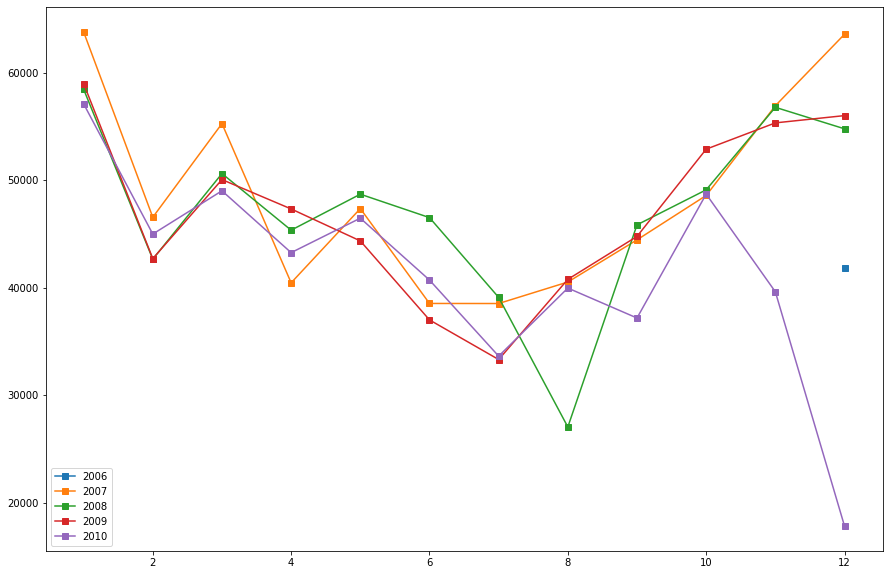

In [98]:
plt.figure(figsize=(15,10))
plt.plot(yearDataDict[2006].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2006',marker='s')
plt.plot(yearDataDict[2007].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2007',marker='s')
plt.plot(yearDataDict[2008].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2008',marker='s')
plt.plot(yearDataDict[2009].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2009',marker='s')
plt.plot(yearDataDict[2010].groupby(['monthOfYear'])['Global_active_power'].sum(),label='2010',marker='s')
plt.legend()

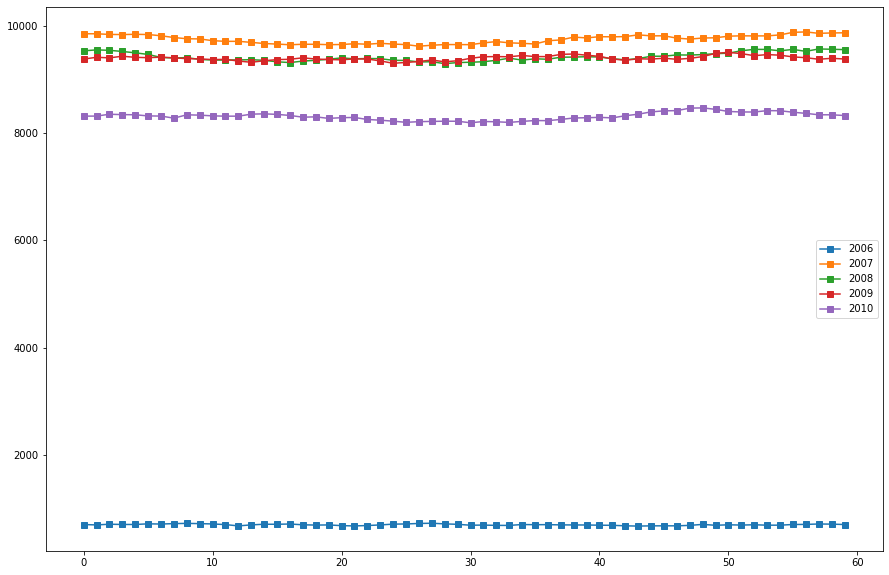

In [99]:
plt.figure(figsize=(15,10))
plt.plot(yearDataDict[2006].groupby(['minOfHour'])['Global_active_power'].sum(),label='2006',marker='s')
plt.plot(yearDataDict[2007].groupby(['minOfHour'])['Global_active_power'].sum(),label='2007',marker='s')
plt.plot(yearDataDict[2008].groupby(['minOfHour'])['Global_active_power'].sum(),label='2008',marker='s')
plt.plot(yearDataDict[2009].groupby(['minOfHour'])['Global_active_power'].sum(),label='2009',marker='s')
plt.plot(yearDataDict[2010].groupby(['minOfHour'])['Global_active_power'].sum(),label='2010',marker='s')
plt.legend()

In [100]:
dataDf.tail(20)

,Global_active_power,dayOfYear,hourOfDay,dayOfWeek,monthOfYear,weekOfYear,year,minOfHour
DateTime,,,,,,,,
2010-11-26 20:43:00,0.988,330,20,4,11,47,2010,43
2010-11-26 20:44:00,0.982,330,20,4,11,47,2010,44
2010-11-26 20:45:00,0.972,330,20,4,11,47,2010,45
2010-11-26 20:46:00,0.908,330,20,4,11,47,2010,46
2010-11-26 20:47:00,0.910,330,20,4,11,47,2010,47
2010-11-26 20:48:00,0.912,330,20,4,11,47,2010,48
2010-11-26 20:49:00,0.948,330,20,4,11,47,2010,49
2010-11-26 20:50:00,1.198,330,20,4,11,47,2010,50
2010-11-26 20:51:00,1.024,330,20,4,11,47,2010,51


Mutivariate CNN for Power consumption Timeseries

In [101]:
# multivariate data preparation
from numpy import array
from numpy import hstack

In [102]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [103]:
dataDf.head()

,Global_active_power,dayOfYear,hourOfDay,dayOfWeek,monthOfYear,weekOfYear,year,minOfHour
DateTime,,,,,,,,
2006-12-16 17:24:00,4.216,350,17,5,12,50,2006,24
2006-12-16 17:25:00,5.360,350,17,5,12,50,2006,25
2006-12-16 17:26:00,5.374,350,17,5,12,50,2006,26
2006-12-16 17:27:00,5.388,350,17,5,12,50,2006,27
2006-12-16 17:28:00,3.666,350,17,5,12,50,2006,28


In [156]:
#Resplit the training and testing dataframes
train_df = dataDf[:int(0.99*len(dataDf))]

In [157]:
test_df = dataDf[int(0.99*len(dataDf))+1:]

In [159]:
# define input sequence
minOfHour = array(train_df['minOfHour'])
dayOfYear = array(train_df['dayOfYear'])
hourOfDay = array(train_df['hourOfDay'])
dayOfWeek = array(train_df['dayOfWeek'])
monthOfYear = array(train_df['monthOfYear'])

In [160]:
globalActivePower = array(train_df['Global_active_power'])

In [161]:
# convert to [rows, columns] structure
minOfHour = minOfHour.reshape((len(dayOfYear), 1))
dayOfYear = dayOfYear.reshape((len(dayOfYear), 1))
hourOfDay = hourOfDay.reshape((len(dayOfYear), 1))
dayOfWeek = dayOfWeek.reshape((len(dayOfYear), 1))
monthOfYear = monthOfYear.reshape((len(dayOfYear), 1))

globalActivePower = globalActivePower.reshape((len(globalActivePower), 1))

In [226]:
# horizontally stack columns
dataset = hstack((minOfHour,hourOfDay,dayOfWeek,dayOfYear,monthOfYear, globalActivePower))
# choose a number of time steps
n_steps = 6
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

(2054501, 6, 5) (2054501,)


In [227]:
# summarize the data
for i in range(5):
 print(X[i], y[i])

[[ 24.  17.   5. 350.  12.]
 [ 25.  17.   5. 350.  12.]
 [ 26.  17.   5. 350.  12.]
 [ 27.  17.   5. 350.  12.]
 [ 28.  17.   5. 350.  12.]
 [ 29.  17.   5. 350.  12.]] 3.52
[[ 25.  17.   5. 350.  12.]
 [ 26.  17.   5. 350.  12.]
 [ 27.  17.   5. 350.  12.]
 [ 28.  17.   5. 350.  12.]
 [ 29.  17.   5. 350.  12.]
 [ 30.  17.   5. 350.  12.]] 3.702
[[ 26.  17.   5. 350.  12.]
 [ 27.  17.   5. 350.  12.]
 [ 28.  17.   5. 350.  12.]
 [ 29.  17.   5. 350.  12.]
 [ 30.  17.   5. 350.  12.]
 [ 31.  17.   5. 350.  12.]] 3.7
[[ 27.  17.   5. 350.  12.]
 [ 28.  17.   5. 350.  12.]
 [ 29.  17.   5. 350.  12.]
 [ 30.  17.   5. 350.  12.]
 [ 31.  17.   5. 350.  12.]
 [ 32.  17.   5. 350.  12.]] 3.668
[[ 28.  17.   5. 350.  12.]
 [ 29.  17.   5. 350.  12.]
 [ 30.  17.   5. 350.  12.]
 [ 31.  17.   5. 350.  12.]
 [ 32.  17.   5. 350.  12.]
 [ 33.  17.   5. 350.  12.]] 3.662


In [228]:
n_features = X.shape[2]

In [229]:
n_steps

6

In [234]:
# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mape')

In [235]:
model.fit(X, y, epochs=10, verbose=1)

Epoch 1/10
64204/64204 [==============================] - 29s 450us/step - loss: 57.8731
Epoch 2/10
64204/64204 [==============================] - 29s 448us/step - loss: 55.9561
Epoch 3/10
64204/64204 [==============================] - 29s 449us/step - loss: 55.9697
Epoch 4/10
64204/64204 [==============================] - 29s 447us/step - loss: 55.9522
Epoch 5/10
64204/64204 [==============================] - 162s 3ms/step - loss: 55.9182
Epoch 6/10
64204/64204 [==============================] - 29s 457us/step - loss: 55.9671
Epoch 7/10
64204/64204 [==============================] - 29s 449us/step - loss: 55.9366
Epoch 8/10
64204/64204 [==============================] - 29s 448us/step - loss: 55.9319
Epoch 9/10
64204/64204 [==============================] - 28s 439us/step - loss: 55.9310
Epoch 10/10
64204/64204 [==============================] - 68s 1ms/step - loss: 55.9355


In [236]:
test_df.head()

,Global_active_power,dayOfYear,hourOfDay,dayOfWeek,monthOfYear,weekOfYear,year,minOfHour
DateTime,,,,,,,,
2010-12-11 11:11:00,1.410,345,11,5,12,49,2010,11
2010-12-11 11:12:00,1.294,345,11,5,12,49,2010,12
2010-12-11 11:13:00,1.302,345,11,5,12,49,2010,13
2010-12-11 11:14:00,1.394,345,11,5,12,49,2010,14
2010-12-11 11:15:00,1.484,345,11,5,12,49,2010,15


In [237]:
test_df.shape

(20752, 8)

In [257]:
# define input sequence
minOfHour_test = array(test_df['minOfHour'])
dayOfYear_test = array(test_df['dayOfYear'])
hourOfDay_test = array(test_df['hourOfDay'])
dayOfWeek_test = array(test_df['dayOfWeek'])
monthOfYear_test = array(test_df['monthOfYear'])

In [258]:
globalActivePower_test = array(test_df['Global_active_power'])

In [259]:
# convert to [rows, columns] structure
minOfHour_test = minOfHour_test.reshape((len(dayOfYear_test), 1))
dayOfYear_test = dayOfYear_test.reshape((len(dayOfYear_test), 1))
hourOfDay_test = hourOfDay_test.reshape((len(dayOfYear_test), 1))
dayOfWeek_test = dayOfWeek_test.reshape((len(dayOfYear_test), 1))
monthOfYear_test = monthOfYear_test.reshape((len(dayOfYear_test), 1))

globalActivePower_test = globalActivePower_test.reshape((len(globalActivePower_test), 1))

In [260]:
# horizontally stack columns
dataset_test = hstack((minOfHour_test,hourOfDay_test,dayOfWeek_test,dayOfYear_test,monthOfYear_test, globalActivePower_test))
# choose a number of time steps
n_steps = 6
# convert into input/output
X_test, y_test = split_sequences(dataset_test, n_steps)
print(X_test.shape, y_test.shape)

(20747, 6, 5) (20747,)


In [261]:
y_test[0]

1.406

In [262]:
# summarize the data
x_input = X_test[:50]
yhat = y_test[:50]

In [263]:
n_steps

6

In [264]:
x_input = x_input.reshape((len(x_input), n_steps, n_features))
yhat_pred = model.predict(x_input, verbose=1)
print(yhat_pred)

2/2 [==============================] - 0s 2ms/step
[[0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]
 [0.26026386]]


In [265]:
m_test = tf.keras.metrics.MeanAbsolutePercentageError()
m_test.update_state(yhat, yhat_pred)
m_test.result().numpy()

81.619255

With Different explanatory variables

In [266]:
# horizontally stack columns
dataset_3vars = hstack((minOfHour,hourOfDay,dayOfWeek,monthOfYear, globalActivePower))
# choose a number of time steps
n_steps = 6
# convert into input/output
X_3vars, y_3vars = split_sequences(dataset_3vars, n_steps)
print(X_3vars.shape, y_3vars.shape)

(2054501, 6, 3) (2054501,)


In [267]:
# summarize the data
for i in range(5):
 print(X_3vars[i], y_3vars[i])

[[24.  5. 12.]
 [25.  5. 12.]
 [26.  5. 12.]
 [27.  5. 12.]
 [28.  5. 12.]
 [29.  5. 12.]] 3.52
[[25.  5. 12.]
 [26.  5. 12.]
 [27.  5. 12.]
 [28.  5. 12.]
 [29.  5. 12.]
 [30.  5. 12.]] 3.702
[[26.  5. 12.]
 [27.  5. 12.]
 [28.  5. 12.]
 [29.  5. 12.]
 [30.  5. 12.]
 [31.  5. 12.]] 3.7
[[27.  5. 12.]
 [28.  5. 12.]
 [29.  5. 12.]
 [30.  5. 12.]
 [31.  5. 12.]
 [32.  5. 12.]] 3.668
[[28.  5. 12.]
 [29.  5. 12.]
 [30.  5. 12.]
 [31.  5. 12.]
 [32.  5. 12.]
 [33.  5. 12.]] 3.662


In [359]:
n_features = X_3vars.shape[2]

In [357]:
n_steps

6

In [270]:
# define model
model_3vars = Sequential()
model_3vars.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_steps, n_features)))
model_3vars.add(MaxPooling1D(pool_size=2))
model_3vars.add(Flatten())
model_3vars.add(Dense(50, activation='relu'))
model_3vars.add(Dense(1))
model_3vars.compile(optimizer='adam', loss='mape')

In [271]:
model_3vars.fit(X_3vars, y_3vars, epochs=20, verbose=1)

Epoch 1/10
64204/64204 [==============================] - 30s 460us/step - loss: 56.5968
Epoch 2/10
64204/64204 [==============================] - 30s 470us/step - loss: 56.0393
Epoch 3/10
64204/64204 [==============================] - 28s 441us/step - loss: 56.0165
Epoch 4/10
64204/64204 [==============================] - 29s 452us/step - loss: 56.0096
Epoch 5/10
64204/64204 [==============================] - 29s 450us/step - loss: 56.0088
Epoch 6/10
64204/64204 [==============================] - 30s 465us/step - loss: 56.0042
Epoch 7/10
64204/64204 [==============================] - 30s 464us/step - loss: 56.0035
Epoch 8/10
64204/64204 [==============================] - 30s 464us/step - loss: 56.0007
Epoch 9/10
64204/64204 [==============================] - 30s 473us/step - loss: 56.0026
Epoch 10/10
64204/64204 [==============================] - 30s 470us/step - loss: 56.0005


In [367]:
# horizontally stack columns
dataset_4vars = hstack((minOfHour,hourOfDay,dayOfWeek,monthOfYear, globalActivePower))
# choose a number of time steps
n_steps = 6
# convert into input/output
X_4vars, y_4vars = split_sequences(dataset_4vars, n_steps)
print(X_4vars.shape, y_4vars.shape)

(2054501, 6, 4) (2054501,)


In [368]:
n_features = X_4vars.shape[2]

In [369]:
# define model with lstm
model_4vars_cnn_lstm = Sequential()
model_4vars_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_4vars_cnn_lstm.add(LSTM(64,return_sequences=True))
#model_3vars_cnn_lstm.add(MaxPooling1D(pool_size=2))
#model_3vars_cnn_lstm.add(Flatten())
model_4vars_cnn_lstm.add(Dense(50, activation='relu'))
model_4vars_cnn_lstm.add(Dense(1))
model_4vars_cnn_lstm.compile(optimizer='adam', loss='mape')

In [370]:
model_4vars_cnn_lstm.fit(X_4vars, y_4vars, epochs=20, verbose=1)

Epoch 1/20
64204/64204 [==============================] - 114s 2ms/step - loss: 56.5380
Epoch 2/20
64204/64204 [==============================] - 115s 2ms/step - loss: 56.4945
Epoch 3/20
64204/64204 [==============================] - 213s 3ms/step - loss: 56.4923
Epoch 4/20
56804/64204 [=========================>....] - ETA: 13s - loss: 56.5018

KeyboardInterrupt: 

In [272]:
test_df.head()

,Global_active_power,dayOfYear,hourOfDay,dayOfWeek,monthOfYear,weekOfYear,year,minOfHour
DateTime,,,,,,,,
2010-12-11 11:11:00,1.410,345,11,5,12,49,2010,11
2010-12-11 11:12:00,1.294,345,11,5,12,49,2010,12
2010-12-11 11:13:00,1.302,345,11,5,12,49,2010,13
2010-12-11 11:14:00,1.394,345,11,5,12,49,2010,14
2010-12-11 11:15:00,1.484,345,11,5,12,49,2010,15


In [237]:
test_df.shape

(20752, 8)

In [257]:
# define input sequence
minOfHour_test = array(test_df['minOfHour'])
dayOfYear_test = array(test_df['dayOfYear'])
hourOfDay_test = array(test_df['hourOfDay'])
dayOfWeek_test = array(test_df['dayOfWeek'])
monthOfYear_test = array(test_df['monthOfYear'])

In [258]:
globalActivePower_test = array(test_df['Global_active_power'])

In [259]:
# convert to [rows, columns] structure
minOfHour_test = minOfHour_test.reshape((len(dayOfYear_test), 1))
dayOfYear_test = dayOfYear_test.reshape((len(dayOfYear_test), 1))
hourOfDay_test = hourOfDay_test.reshape((len(dayOfYear_test), 1))
dayOfWeek_test = dayOfWeek_test.reshape((len(dayOfYear_test), 1))
monthOfYear_test = monthOfYear_test.reshape((len(dayOfYear_test), 1))

globalActivePower_test = globalActivePower_test.reshape((len(globalActivePower_test), 1))

In [273]:
# horizontally stack columns
dataset_test = hstack((minOfHour_test,dayOfWeek_test,monthOfYear_test, globalActivePower_test))
# choose a number of time steps
n_steps = 6
# convert into input/output
X_test, y_test = split_sequences(dataset_test, n_steps)
print(X_test.shape, y_test.shape)

(20747, 6, 3) (20747,)


In [274]:
y_test[0]

1.406

In [275]:
# summarize the data
x_input = X_test[:50]
yhat = y_test[:50]

In [276]:
n_steps

6

In [277]:
x_input = x_input.reshape((len(x_input), n_steps, n_features))
yhat_pred = model_3vars.predict(x_input, verbose=1)
print(yhat_pred)

2/2 [==============================] - 0s 2ms/step
[[0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]
 [0.25906095]]


In [278]:
m3vars_test = tf.keras.metrics.MeanAbsolutePercentageError()
m3vars_test.update_state(yhat, yhat_pred)
m3vars_test.result().numpy()

81.70421

Single variable - only global_power

In [281]:
# horizontally stack columns
dataset_1vars = hstack(globalActivePower)
# choose a number of time steps
n_steps = 6
# convert into input/output
X_1vars, y_1vars = split_sequence(dataset_1vars, n_steps)
print(X_1vars.shape, y_1vars.shape)

(2054500, 6) (2054500,)


In [333]:
n_features = 1 #X_1vars.shape[2]

In [334]:
n_steps

6

In [286]:
# define model
model_1vars = Sequential()
model_1vars.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_steps, n_features)))
model_1vars.add(MaxPooling1D(pool_size=2))
model_1vars.add(Flatten())
model_1vars.add(Dense(50, activation='relu'))
model_1vars.add(Dense(1))
model_1vars.compile(optimizer='adam', loss='mape')

In [287]:
model_1vars.fit(X_1vars, y_1vars, epochs=20, verbose=1)

Epoch 1/20
64204/64204 [==============================] - 30s 466us/step - loss: 7.8772
Epoch 2/20
64204/64204 [==============================] - 28s 438us/step - loss: 7.2938
Epoch 3/20
64204/64204 [==============================] - 28s 437us/step - loss: 7.1603
Epoch 4/20
64204/64204 [==============================] - 28s 438us/step - loss: 7.0781
Epoch 5/20
64204/64204 [==============================] - 28s 432us/step - loss: 7.0265
Epoch 6/20
64204/64204 [==============================] - 27s 427us/step - loss: 6.9867
Epoch 7/20
64204/64204 [==============================] - 30s 462us/step - loss: 6.9568
Epoch 8/20
64204/64204 [==============================] - 30s 466us/step - loss: 6.9345
Epoch 9/20
64204/64204 [==============================] - 30s 463us/step - loss: 6.9186
Epoch 10/20
64204/64204 [==============================] - 30s 464us/step - loss: 6.9000
Epoch 11/20
64204/64204 [==============================] - 280s 4ms/step - loss: 6.8822
Epoch 12/20
64204/64204 [======

In [288]:
test_df.head()

,Global_active_power,dayOfYear,hourOfDay,dayOfWeek,monthOfYear,weekOfYear,year,minOfHour
DateTime,,,,,,,,
2010-12-11 11:11:00,1.410,345,11,5,12,49,2010,11
2010-12-11 11:12:00,1.294,345,11,5,12,49,2010,12
2010-12-11 11:13:00,1.302,345,11,5,12,49,2010,13
2010-12-11 11:14:00,1.394,345,11,5,12,49,2010,14
2010-12-11 11:15:00,1.484,345,11,5,12,49,2010,15


In [289]:
test_df.shape

(20752, 8)

In [290]:
# define input sequence
minOfHour_test = array(test_df['minOfHour'])
dayOfYear_test = array(test_df['dayOfYear'])
hourOfDay_test = array(test_df['hourOfDay'])
dayOfWeek_test = array(test_df['dayOfWeek'])
monthOfYear_test = array(test_df['monthOfYear'])

# convert to [rows, columns] structure
minOfHour_test = minOfHour_test.reshape((len(dayOfYear_test), 1))
dayOfYear_test = dayOfYear_test.reshape((len(dayOfYear_test), 1))
hourOfDay_test = hourOfDay_test.reshape((len(dayOfYear_test), 1))
dayOfWeek_test = dayOfWeek_test.reshape((len(dayOfYear_test), 1))
monthOfYear_test = monthOfYear_test.reshape((len(dayOfYear_test), 1))

In [291]:
globalActivePower_test = array(test_df['Global_active_power'])

globalActivePower_test = globalActivePower_test.reshape((len(globalActivePower_test), 1))

In [328]:
# horizontally stack columns
dataset_test = hstack(globalActivePower_test)
# choose a number of time steps
n_steps = 6
# convert into input/output
X_test, y_test = split_sequence(dataset_test, n_steps)
print(X_test.shape, y_test.shape)

(20746, 6) (20746,)


In [329]:
y_test[0]

1.376

In [343]:
# summarize the data
x_input = X_test[400:500]
yhat = y_test[400:500]

In [345]:
n_features

1

In [346]:
x_input = x_input.reshape((len(x_input), n_steps, n_features))
yhat_pred = model_1vars.predict(x_input, verbose=1)
print(yhat_pred)

4/4 [==============================] - 0s 857us/step
[[2.142162 ]
 [1.5512936]
 [1.7933664]
 [1.646018 ]
 [1.7318712]
 [1.8005127]
 [1.8449802]
 [1.9078445]
 [1.9300182]
 [2.284178 ]
 [2.2832675]
 [2.2836745]
 [1.9731684]
 [2.0646124]
 [2.2639651]
 [2.2606382]
 [2.3953397]
 [2.1670535]
 [2.368019 ]
 [2.4301825]
 [2.4080625]
 [2.4905381]
 [2.5534012]
 [2.5364127]
 [2.6122522]
 [2.2119615]
 [2.32     ]
 [2.2083182]
 [2.1561036]
 [2.17714  ]
 [2.178431 ]
 [2.1923115]
 [2.1594956]
 [2.171435 ]
 [2.1846375]
 [2.18859  ]
 [2.2048976]
 [2.1875448]
 [2.173639 ]
 [2.1779   ]
 [2.1919124]
 [2.1869946]
 [2.1793056]
 [2.1776214]
 [2.2035122]
 [2.276259 ]
 [2.246116 ]
 [2.2379594]
 [2.258084 ]
 [2.2488406]
 [2.2466724]
 [2.2557175]
 [2.2550058]
 [2.2529747]
 [2.2263744]
 [2.2489517]
 [2.3023424]
 [2.3318157]
 [2.463979 ]
 [2.5305057]
 [2.2300727]
 [2.2588232]
 [2.4456382]
 [2.257779 ]
 [3.3071587]
 [3.441784 ]
 [3.4423213]
 [3.5051854]
 [2.2876287]
 [2.4082015]
 [2.4334457]
 [1.8928888]
 [2.228429 

In [347]:
m1vars_test = tf.keras.metrics.MeanAbsolutePercentageError()
m1vars_test.update_state(yhat, yhat_pred)
m1vars_test.result().numpy()

6.9581246

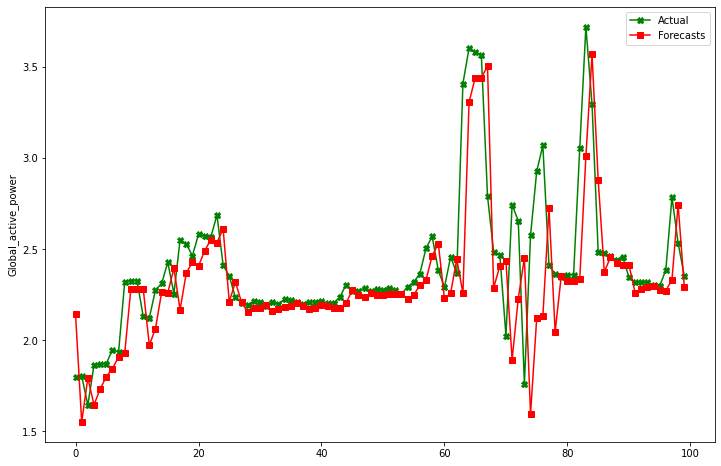

In [348]:
plt.figure(figsize=(12, 8))
plt.ylabel('Global_active_power')
plt.plot(yhat,c='green',marker='X',label='Actual')
plt.plot(yhat_pred,c='red',marker='s',label='Forecasts')
plt.legend()

Single variable CNN-LSTM Model

In [391]:
# horizontally stack columns
dataset_1vars = hstack(globalActivePower)
# choose a number of time steps
n_steps = 10
# convert into input/output
X_1vars, y_1vars = split_sequence(dataset_1vars, n_steps)
print(X_1vars.shape, y_1vars.shape)

(2054496, 10) (2054496,)


In [392]:
n_features = 1 #X_1vars.shape[2]

In [393]:
n_steps

10

In [400]:
# define model
model_1vars_cnn_lstm = Sequential()
model_1vars_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_1vars_cnn_lstm.add(LSTM(64,return_sequences=True))
model_1vars_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_1vars_cnn_lstm.add(Flatten())
model_1vars_cnn_lstm.add(Dense(50, activation='relu'))
model_1vars_cnn_lstm.add(Dense(1))
model_1vars_cnn_lstm.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [401]:
model_1vars_cnn_lstm.fit(X_1vars, y_1vars, epochs=10, verbose=1)

Epoch 1/10
64203/64203 [==============================] - 158s 2ms/step - loss: 0.0657 - root_mean_squared_error: 0.2562
Epoch 2/10
64203/64203 [==============================] - 157s 2ms/step - loss: 0.0598 - root_mean_squared_error: 0.2445
Epoch 3/10
64203/64203 [==============================] - 137s 2ms/step - loss: 0.0581 - root_mean_squared_error: 0.2411
Epoch 4/10
64203/64203 [==============================] - 418s 7ms/step - loss: 0.0572 - root_mean_squared_error: 0.2391
Epoch 5/10
64203/64203 [==============================] - 154s 2ms/step - loss: 0.0565 - root_mean_squared_error: 0.2377
Epoch 6/10
64203/64203 [==============================] - 153s 2ms/step - loss: 0.0560 - root_mean_squared_error: 0.2366
Epoch 7/10
64203/64203 [==============================] - 155s 2ms/step - loss: 0.0555 - root_mean_squared_error: 0.2357
Epoch 8/10
64203/64203 [==============================] - 801s 12ms/step - loss: 0.0552 - root_mean_squared_error: 0.2350
Epoch 9/10
64203/64203 [=======

In [288]:
test_df.head()

,Global_active_power,dayOfYear,hourOfDay,dayOfWeek,monthOfYear,weekOfYear,year,minOfHour
DateTime,,,,,,,,
2010-12-11 11:11:00,1.410,345,11,5,12,49,2010,11
2010-12-11 11:12:00,1.294,345,11,5,12,49,2010,12
2010-12-11 11:13:00,1.302,345,11,5,12,49,2010,13
2010-12-11 11:14:00,1.394,345,11,5,12,49,2010,14
2010-12-11 11:15:00,1.484,345,11,5,12,49,2010,15


In [289]:
test_df.shape

(20752, 8)

In [377]:
# define input sequence
minOfHour_test = array(test_df['minOfHour'])
dayOfYear_test = array(test_df['dayOfYear'])
hourOfDay_test = array(test_df['hourOfDay'])
dayOfWeek_test = array(test_df['dayOfWeek'])
monthOfYear_test = array(test_df['monthOfYear'])

# convert to [rows, columns] structure
minOfHour_test = minOfHour_test.reshape((len(dayOfYear_test), 1))
dayOfYear_test = dayOfYear_test.reshape((len(dayOfYear_test), 1))
hourOfDay_test = hourOfDay_test.reshape((len(dayOfYear_test), 1))
dayOfWeek_test = dayOfWeek_test.reshape((len(dayOfYear_test), 1))
monthOfYear_test = monthOfYear_test.reshape((len(dayOfYear_test), 1))

In [378]:
globalActivePower_test = array(test_df['Global_active_power'])

globalActivePower_test = globalActivePower_test.reshape((len(globalActivePower_test), 1))

In [379]:
# horizontally stack columns
dataset_test = hstack(globalActivePower_test)
# choose a number of time steps
n_steps = 6
# convert into input/output
X_test, y_test = split_sequence(dataset_test, n_steps)
print(X_test.shape, y_test.shape)

(20746, 6) (20746,)


In [380]:
y_test[0]

1.376

In [381]:
# summarize the data
x_input = X_test[400:500]
yhat = y_test[400:500]

In [382]:
n_features

1

In [383]:
x_input = x_input.reshape((len(x_input), n_steps, n_features))
yhat_pred = model_1vars.predict(x_input, verbose=1)
#print(yhat_pred)

4/4 [==============================] - 0s 1ms/step


In [384]:
m1vars_test = tf.keras.metrics.MeanAbsolutePercentageError()
m1vars_test.update_state(yhat, yhat_pred)
m1vars_test.result().numpy()

6.23232

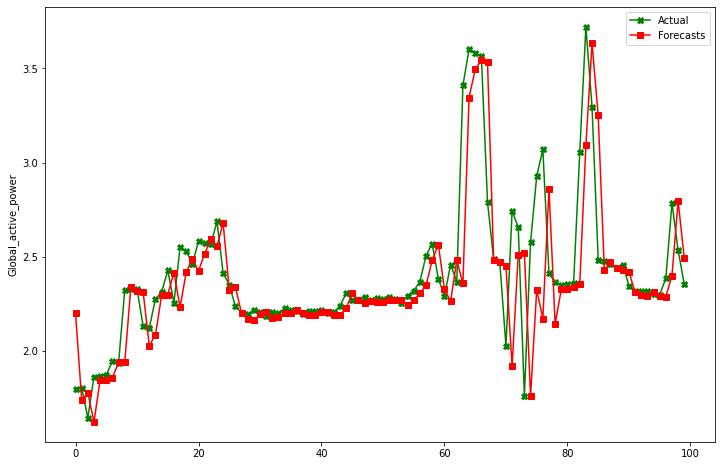

In [385]:
plt.figure(figsize=(12, 8))
plt.ylabel('Global_active_power')
plt.plot(yhat,c='green',marker='X',label='Actual')
plt.plot(yhat_pred,c='red',marker='s',label='Forecasts')
plt.legend()

Two Vars model

In [300]:
# horizontally stack columns
dataset_3vars = hstack((minOfHour,dayOfWeek,monthOfYear, globalActivePower))
# choose a number of time steps
n_steps = 6
# convert into input/output
X_2vars, y_2vars = split_sequences(dataset_2vars, n_steps)
print(X_2vars.shape, y_2vars.shape)

(2054501, 6, 2) (2054501,)


In [301]:
n_features = X_2vars.shape[2]

In [302]:
n_steps

6

In [303]:
# define model
model_2vars = Sequential()
model_2vars.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_steps, n_features)))
model_2vars.add(MaxPooling1D(pool_size=2))
model_2vars.add(Flatten())
model_2vars.add(Dense(50, activation='relu'))
model_2vars.add(Dense(1))
model_2vars.compile(optimizer='adam', loss='mape')

In [304]:
model_2vars.fit(X_2vars, y_2vars, epochs=20, verbose=1)

Epoch 1/20
64204/64204 [==============================] - 30s 467us/step - loss: 55.5826
Epoch 2/20
64204/64204 [==============================] - 31s 481us/step - loss: 55.4044
Epoch 3/20
64204/64204 [==============================] - 29s 459us/step - loss: 55.3795
Epoch 4/20
64204/64204 [==============================] - 29s 457us/step - loss: 55.3652
Epoch 5/20
64204/64204 [==============================] - 31s 477us/step - loss: 55.3610
Epoch 6/20
64204/64204 [==============================] - 30s 475us/step - loss: 55.3544
Epoch 7/20
64204/64204 [==============================] - 30s 473us/step - loss: 55.3533
Epoch 8/20
64204/64204 [==============================] - 30s 464us/step - loss: 55.3513
Epoch 9/20
64204/64204 [==============================] - 30s 466us/step - loss: 55.3513
Epoch 10/20
64204/64204 [==============================] - 31s 483us/step - loss: 55.3497
Epoch 11/20
64204/64204 [==============================] - 34s 527us/step - loss: 55.3481
Epoch 12/20
64204/6

In [305]:
test_df.head()

,Global_active_power,dayOfYear,hourOfDay,dayOfWeek,monthOfYear,weekOfYear,year,minOfHour
DateTime,,,,,,,,
2010-12-11 11:11:00,1.410,345,11,5,12,49,2010,11
2010-12-11 11:12:00,1.294,345,11,5,12,49,2010,12
2010-12-11 11:13:00,1.302,345,11,5,12,49,2010,13
2010-12-11 11:14:00,1.394,345,11,5,12,49,2010,14
2010-12-11 11:15:00,1.484,345,11,5,12,49,2010,15


In [306]:
test_df.shape

(20752, 8)

In [307]:
# define input sequence
minOfHour_test = array(test_df['minOfHour'])
dayOfYear_test = array(test_df['dayOfYear'])
hourOfDay_test = array(test_df['hourOfDay'])
dayOfWeek_test = array(test_df['dayOfWeek'])
monthOfYear_test = array(test_df['monthOfYear'])

# convert to [rows, columns] structure
minOfHour_test = minOfHour_test.reshape((len(dayOfYear_test), 1))
dayOfYear_test = dayOfYear_test.reshape((len(dayOfYear_test), 1))
hourOfDay_test = hourOfDay_test.reshape((len(dayOfYear_test), 1))
dayOfWeek_test = dayOfWeek_test.reshape((len(dayOfYear_test), 1))
monthOfYear_test = monthOfYear_test.reshape((len(dayOfYear_test), 1))

In [308]:
globalActivePower_test = array(test_df['Global_active_power'])

globalActivePower_test = globalActivePower_test.reshape((len(globalActivePower_test), 1))

In [310]:
# horizontally stack columns
dataset_2test = hstack((dayOfWeek_test,monthOfYear_test, globalActivePower_test))
# choose a number of time steps
n_steps = 6
# convert into input/output
X_2test, y_2test = split_sequences(dataset_2test, n_steps)
print(X_2test.shape, y_2test.shape)

(20747, 6, 2) (20747,)


In [294]:
y_2test[0]

1.376

In [311]:
# summarize the data
x_2input = X_2test[:50]
yhat2 = y_2test[:50]

In [312]:
n_steps

6

In [319]:
x_2input = x_2input.reshape((len(x_2input), n_steps, n_features))
yhat_2pred = model_2vars.predict(x_2input, verbose=1)
print(yhat_2pred)
print(yhat2)

2/2 [==============================] - 0s 1ms/step
[[0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]
 [0.3060677]]
[1.406 1.376 1.376 1.372 1.366 1.37  1.382 1.384 1.384 1.432 1.454 1.454
 1.538 1.552 1.55  1.552 1.55  1.498 1.474 1.466 1.476 1.474 1.462 1.458
 1.464 1.476 1.476 1.468 1.466 1.45  1.376 1.374 1.364 1.358 1.36  1.364
 1.37  1.372 1.37  1.366 1.364 1.364 1.368 1.36  1.348 1.352 1.36  1.352
 1.348

In [317]:
m2vars_test = tf.keras.metrics.MeanAbsolutePercentageError()
m2vars_test.update_state(yhat2, yhat_2pred)
m2vars_test.result().numpy()

78.38443

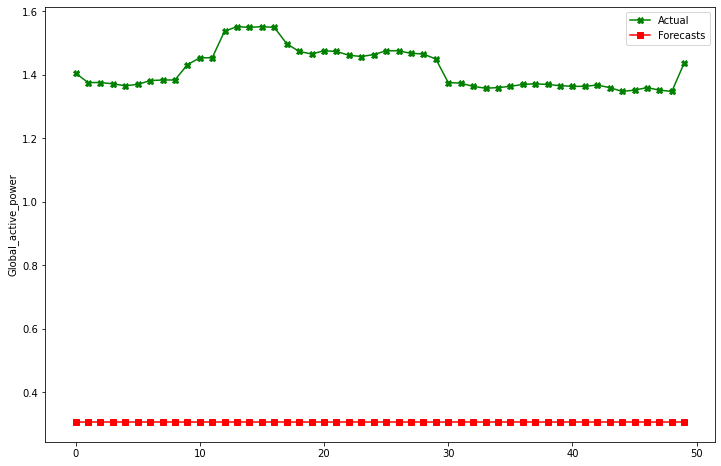

In [318]:
plt.figure(figsize=(12, 8))
plt.ylabel('Global_active_power')
plt.plot(yhat2,c='green',marker='X',label='Actual')
plt.plot(yhat_2pred,c='red',marker='s',label='Forecasts')
plt.legend()